# 全球购策略

标的：美国国债指数、标普500、恒生指数、沪深300
回测时间：2012年1月1日 - 2019年3月28日

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
%matplotlib inline

In [2]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret, risk_free=0.015/365)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

## 读取数据

### Total Return Index

In [44]:
total_ret = pd.read_excel('../data/total return index.xlsx', index_col=0)

In [45]:
total_ret.head()

,LUATTRUU Index,HSI 1 Index,SPXT Index,CSIR0300 Index
Dates,,,,
2010-01-01,1741.11,44382.29,1837.50,3739.99
2010-01-04,1742.60,44282.42,1867.06,3697.67
2010-01-05,1749.88,45208.32,1872.90,3727.81
2010-01-06,1746.49,45486.49,1874.73,3704.47
2010-01-07,1745.02,45187.77,1882.34,3630.97


In [47]:
total_ret = total_ret.pct_change()

### 读取美元兑人民币汇率，计算人民币收益

In [86]:
usdcny = pd.read_excel('../data/usdcny.xlsx', skiprows=1, index_col=0)

In [88]:
usdcny = usdcny.pct_change()

In [94]:
total_ret_cny = total_ret.merge(usdcny, left_index=True, right_index=True)

In [97]:
total_ret_cny[u'即期汇率:美元兑人民币'] = total_ret_cny[u'即期汇率:美元兑人民币'].fillna(0).dropna()

In [100]:
total_ret_cny.tail()

,LUATTRUU Index,HSI 1 Index,SPXT Index,CSIR0300 Index,即期汇率:美元兑人民币
2019-05-16,-0.001489,0.001578,0.009185,0.004540,0.001237
2019-05-17,0.000778,-0.011229,-0.005736,-0.025396,0.004606
2019-05-20,-0.000905,-0.004894,-0.006734,-0.008487,0.000043
2019-05-21,-0.000906,-0.002005,0.008522,0.013650,0.000362
2019-05-22,0.001836,0.001840,-0.002804,-0.004740,-0.001822


In [103]:
total_ret_cny['LUATTRUU Index'] *= (1-total_ret_cny[u'即期汇率:美元兑人民币'])
total_ret_cny['HSI 1 Index'] *= (1-total_ret_cny[u'即期汇率:美元兑人民币'])
total_ret_cny['SPXT Index'] *= (1-total_ret_cny[u'即期汇率:美元兑人民币'])

In [112]:
total_ret_cny = total_ret_cny[total_ret_cny.index >= '2012-01-01'][total_ret.columns[:4]]

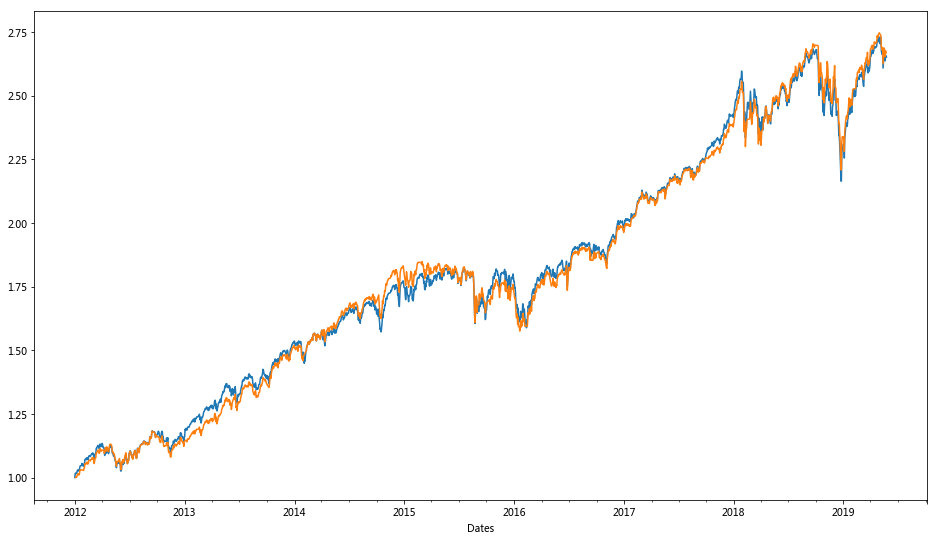

In [114]:
(1+total_ret[total_ret.index >= '2012-01-01']['SPXT Index']).cumprod().plot(figsize=(16, 9))
(1+total_ret_cny['SPXT Index']).cumprod().plot(figsize=(16, 9))

### 读取股指历史PE

In [432]:
pe_ratio = pd.read_excel('../data/hs&sh pe ratio.xlsx')

In [433]:
sp_pe = pd.read_excel('../data/sp500 pe ratio.xlsx', index_col=0)

In [434]:
pe_ratio = pe_ratio.merge(sp_pe, left_index=True, right_index=True)

In [435]:
pe_ratio = pe_ratio.fillna(method='ffill')

In [436]:
pe_ratio.head()

,HSI.HI,000001.SH,SPX Index
2006-01-04,13.8540,18.394199,17.2013
2006-01-05,13.9187,18.631300,17.2018
2006-01-06,13.9856,18.816200,17.3637
2006-01-09,14.1628,18.907101,17.4251
2006-01-10,14.1910,18.982500,17.4188


### 读取联邦基金目标利率

In [129]:
fed_rate = pd.read_excel('../data/fed rate.xlsx', skiprows=1, index_col=0)

In [131]:
fed_rate.tail()

,美国:联邦基金目标利率
指标名称,
2017-12-14,1.50
2018-03-22,1.75
2018-06-14,2.00
2018-09-27,2.25
2018-12-20,2.50


In [134]:
fed_rate['rate change'] = fed_rate.diff()

In [138]:
fed_rate.tail()

,美国:联邦基金目标利率,rate change
指标名称,,
2017-12-14,1.50,0.25
2018-03-22,1.75,0.25
2018-06-14,2.00,0.25
2018-09-27,2.25,0.25
2018-12-20,2.50,0.25


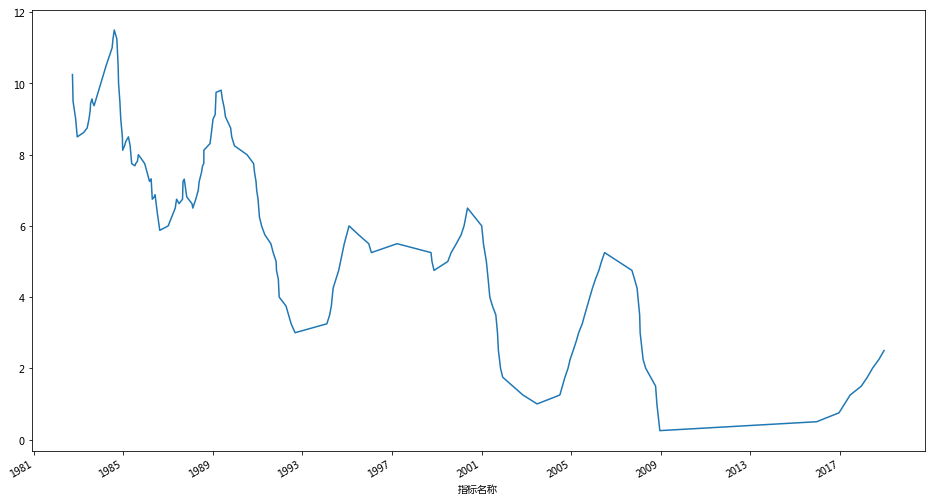

In [181]:
fed_rate[u'美国:联邦基金目标利率'].plot(figsize=(16, 9))

## 历史回测

### 回测情形1：只考虑联邦基金利率的变化

股债配置比例：以美联储加息、降息的货币周期为依据，当美联储加息时，说明未来经济大概率向好，超配股票，低配债；当美联储降息时，说明经济较差，低配股票；超配债；具体阈值设计如下：
   
* 美联储加息：债=0%，股=100%
* 美联储降息：债=20%，股=80%
* **最近一年**无政策：债=10%，股=90%

In [412]:
# 判断当前状态
def regime_weight(date):
    previous_rate_change = fed_rate[fed_rate.index <= date].iloc[-1]
    rate_change, previous_date = previous_rate_change['rate change'], previous_rate_change.name
    if (date - previous_date).days > 90: # 最近一年无政策
        return np.array([0.1, 0.3, 0.3, 0.3])
    else:
        if rate_change > 0: # 加息
            return np.array([0., 1./3, 1./3, 1./3])
        else: # 降息
            return np.array([0.2, 0.8/3, 0.8/3, 0.8/3])

In [414]:
# initilization
n = total_ret_cny.shape[1] # number of assets
wb = np.array([0.1, 0.3, 0.3, 0.3]) # weight of one day
weight = pd.DataFrame(columns=total_ret_cny.columns, index=total_ret_cny.index) # weight of historical data
past_months = set([])

for date in total_ret_cny.index:
    weight.loc[date] = wb

    this_month = '%d-%d'%(date.year, date.month)
    # rebalance on first day of one month
    if this_month not in past_months:
#         print(date)
        past_months.add(this_month)
        wb = regime_weight(date)
        
    wb = wb * (1 + total_ret_cny.loc[date])
    wb /= wb.sum()

In [415]:
portfolio1 = (weight * total_ret_cny).sum(axis=1)

In [416]:
metric(portfolio1)

Annual return: 10.21%
Sharpe ratio: 0.76
Annual volatility: 12.41%
Max drawdown: -29.57%


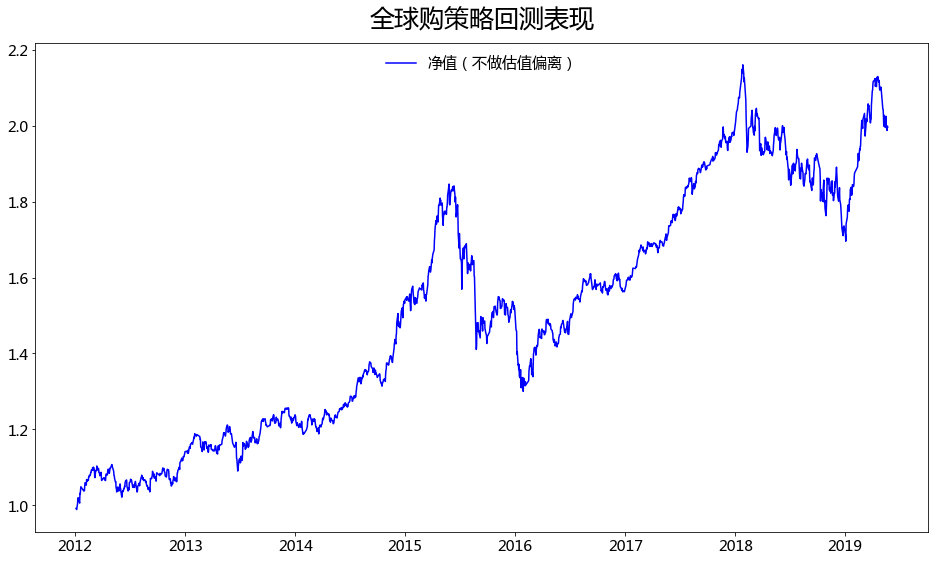

In [417]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio1).cumprod(), color='blue', label=u'净值（不做估值偏离）')

lns = lns1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'全球购策略回测表现', fontsize=25, y=1.02)

In [418]:
weight = weight.astype(np.float32)

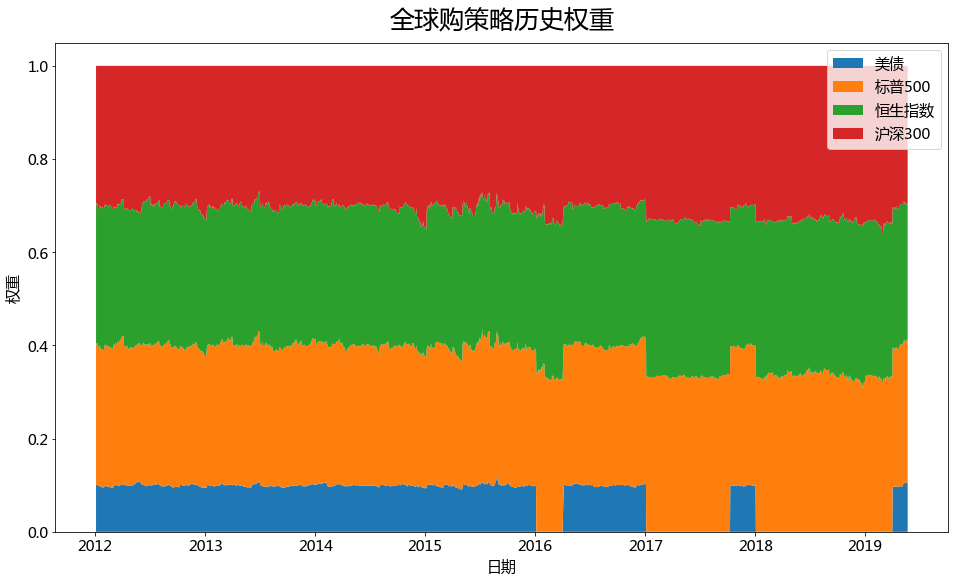

In [419]:
fig, ax = plt.subplots(figsize=(16, 9))

_ = ax.stackplot(weight.index, 
                 weight['LUATTRUU Index'],
                 weight['SPXT Index'],
                 weight['HSI 1 Index'],
                 weight['CSIR0300 Index'],
                 labels=[u'美债', u'标普500', u'恒生指数', u'沪深300'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

### 回测情形2：除了情形1的两种调仓情况外，加入估值判断

权益资产内部配置：实时跟踪指数与其历史估值中枢的偏离度，当超过估值中枢一定水平后，低配该指数，反之高配；具体阈值设计如下（权益资产内部比例情况，仅列出估值高于中枢的情况，当估值低于中枢的时候也类似），根据偏离度调整配置比例后，再根据股票总仓位进行整体 “归一”调整。

* 10%<=估值偏离度<=20%，标配仓位基础上+15%
* 20%<=估值偏离度<=30%，标配仓位基础上+25%
* 30%<=估值偏离度，标配仓位基础上35%

### 计算估值偏离度

In [437]:
pe_dev = pe_ratio.rolling(243*5).apply(lambda x: (x[-1] - x.mean())/x.mean()).dropna()

In [438]:
pe_dev = pe_dev[pe_dev.index >= '2012-01-01']

In [439]:
pe_dev.tail()

,HSI.HI,000001.SH,SPX Index
2019-05-16,-0.036219,-0.078417,-0.030309
2019-05-17,-0.047552,-0.100489,-0.036085
2019-05-20,-0.053369,-0.103390,-0.042572
2019-05-21,-0.056149,-0.093192,-0.034506
2019-05-22,-0.056484,-0.097645,-0.037306


In [423]:
def weight_change(w, dev):
    if dev < -0.3:
        return w + 0.35
    elif -0.3 <= dev and dev < -0.2:
        return w + 0.25
    elif -0.2 <= dev and dev < -0.1:
        return w + 0.15
    elif 0.1 <= dev and dev < 0.2:
        return max(0, w - 0.15)
    elif 0.2 <= dev and dev < 0.3:
        return max(0, w - 0.25)
    elif dev >= 0.3:
        return max(0, w - 0.35)
    else:
        return w

In [424]:
def calc_weight(date):
    w = regime_weight(date)
#     print(w)
    current_pe_dev = pe_dev[pe_dev.index <= date].iloc[-1]
#     print(current_pe_dev)
    init_w = w[1] + w[2] + w[3]
    w[1] = weight_change(w[1], current_pe_dev['HSI.HI'])
    w[2] = weight_change(w[2], current_pe_dev['SPX Index'])
    w[3] = weight_change(w[3], current_pe_dev['000300.SH'])
#     print(w)
    sum_w = w[1] + w[2] + w[3]
    w[1] = w[1] * init_w / sum_w
    w[2] = w[2] * init_w / sum_w
    w[3] = w[3] * init_w / sum_w
#     print(w)
    return w

In [425]:
# initilization
n = total_ret_cny.shape[1] # number of assets
wb = np.array([0.1, 0.3, 0.3, 0.3]) # weight of one day
weight = pd.DataFrame(columns=total_ret_cny.columns, index=total_ret_cny.index) # weight of historical data
past_months = set([])

for date in total_ret_cny.index:
    weight.loc[date] = wb
#     wb = calc_weight(date)
    
    
#     # rebalance of fed rate change day
#     if date in fed_rate.index:
#         print("%s Fed Rate Change"%(date))
#         wb = calc_weight(date)
# #         print('')

    this_month = '%d-%d'%(date.year, date.month)
    # rebalance on first day of one month
    if this_month not in past_months:
#         print(date)
        past_months.add(this_month)
        wb = calc_weight(date)
#         print('')
        
    wb = wb * (1 + total_ret_cny.loc[date]) 
    wb /= wb.sum()

In [426]:
portfolio2 = (weight * total_ret_cny).sum(axis=1)

In [427]:
metric(portfolio2)

Annual return: 11.73%
Sharpe ratio: 0.86
Annual volatility: 12.59%
Max drawdown: -27.83%


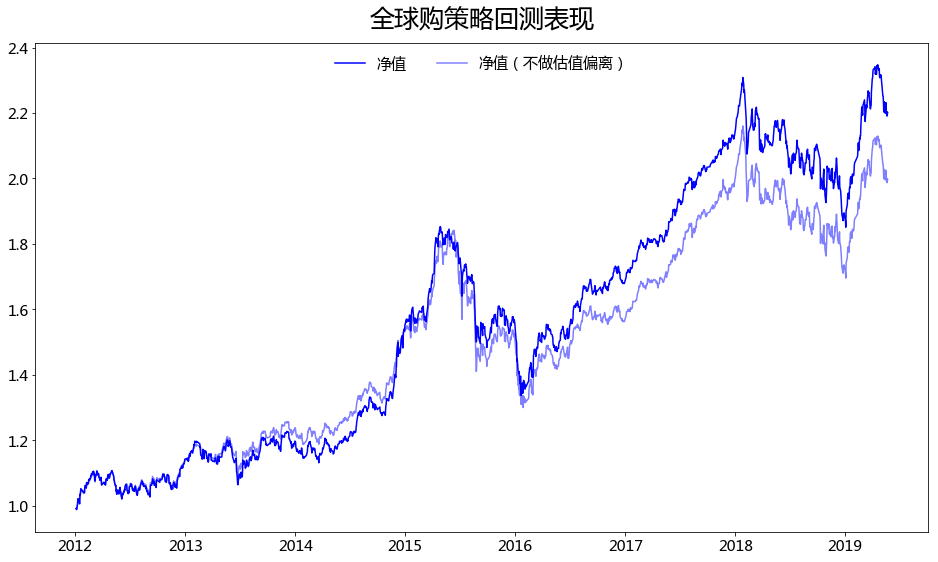

In [428]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio2).cumprod(), color='blue', label=u'净值')
lns2 = ax.plot((1 + portfolio1).cumprod(), color='blue', alpha=0.5, label=u'净值（不做估值偏离）')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'全球购策略回测表现', fontsize=25, y=1.02)

In [429]:
weight = weight.astype(np.float32)

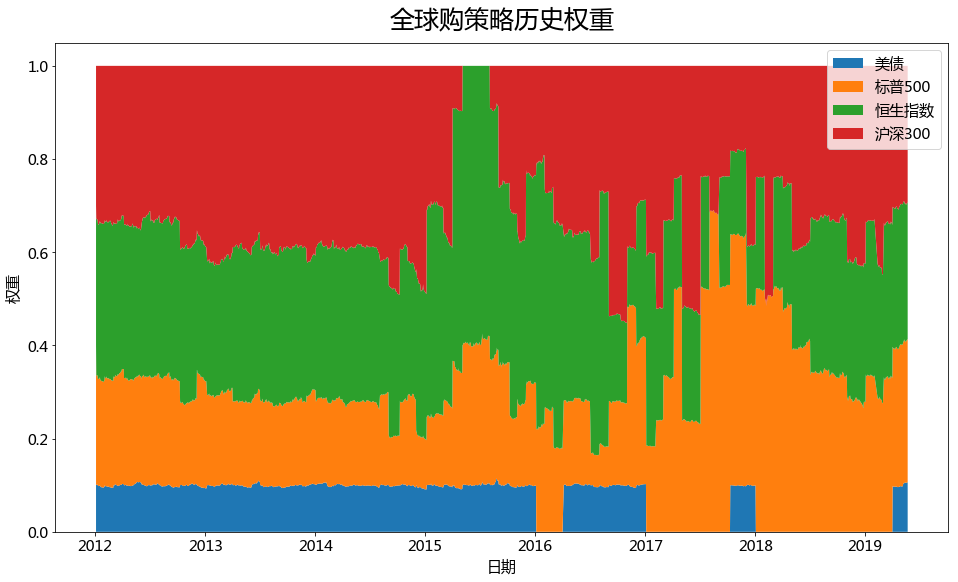

In [431]:
fig, ax = plt.subplots(figsize=(16, 9))

_ = ax.stackplot(weight.index, 
                 weight['LUATTRUU Index'],
                 weight['SPXT Index'],
                 weight['HSI 1 Index'],
                 weight['CSIR0300 Index'],
                 labels=[u'美债', u'标普500', u'恒生指数', u'沪深300'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

In [349]:
weight.to_excel('../data/weight.xlsx')